# Python Foundation For Spatial Analysis: Finding Solar Sites from OpenStreetMap

This is a final project by Colby Smith for the completion of the Python Foundation for Spatial Analysis course presented by Ujaval Gandhi of Spatial Thoughts. 

I explore the OSMnx python library, and I find the total acreage of solar sites in Massachusetts by county.

Links consulted to complete this project:
- [OSMnx User Reference](https://osmnx.readthedocs.io/en/stable/user-reference.html#)
- [OSMnx Examples Gallery](https://github.com/gboeing/osmnx-examples)
- [OpenStreetMap Wiki for Solar Generators Tag](https://wiki.openstreetmap.org/wiki/Tag:generator:source%3Dsolar)

## Load Libraries

In [1]:
import geopandas as gpd
import osmnx as ox

By default, using the OSMnx tools will generate a cache folder in the local directory. Instead of repeatedly hitting the server with the same query as I was testing this code, the cache saves my responses.

## Using OSM to Find Solar Sites by Location

North Brookfield is a town I have developed solar projects in before, so I am familiar with their shape and location. I can query OSM for photovoltaic power plants using tags and display their polygons on a map.

In [2]:
place = "North Brookfield, Massachusetts, USA"
tags = {"plant:method": "photovoltaic"}
nbf_solar = ox.features.features_from_place(place, tags)
nbf_solar.explore()

What about finding the total number of solar sites in North Brookfield's county, Worcester?

In [3]:
place = "Worcester County, Massachusetts, United States"
wst_solar = ox.features.features_from_place(place, tags)
wst_solar_count = len(wst_solar)
print(f"There are {wst_solar_count} solar sites in Worcester County.")

There are 272 solar sites in Worcester County.


How many are there in the whole state of Massachusetts?

In [4]:
#Querying over the whole state can cause an error. The following increases the max query area size:
ox.settings.max_query_area_size = 1e12

#Now the below query will work.
place = "Massachusetts, United States"
ma_solar = ox.features.features_from_place(place, tags)
ma_solar_count = len(ma_solar)
print(f"There are {ma_solar_count} solar sites in Massachusetts.")

There are 926 solar sites in Massachusetts.


To find the total acreage of sites in MA, the geodataframe needs to be projected to UTM and the area sum is converted from square meters to acres.

In [5]:
ma_solar_p = ox.projection.project_gdf(ma_solar)
ma_solar_acres = int(ma_solar_p.area.sum()/4046.86)
print(f"There are {ma_solar_acres} acres of solar sites in MA." )

There are 9605 acres of solar sites in MA.


# How Many Acreas of Solar Sites Are In Each County?

Looking at the map of solar sites in North Brookfield, some sites are comprised of multiple arrays. These are represented as mutipolygons in the GeoDataFrame, and can span multiple towns and counties. To prevent double counting, I convert the geodataframe into single polygons with `explode()`.

In [6]:
ma_solar_p_explode = ma_solar_p.explode()
print(f"There are {len(ma_solar_p_explode)} solar arrays in MA." )

There are 1209 solar arrays in MA.


I can then add an area column to each array.

In [7]:
ma_solar_p_explode['area'] = ma_solar_p_explode['geometry'].area

Next, I am able to get the county boundaries from OSM as a GeoDataFrame. I project it to UTM so that it is consistent with the solar array GeoDataFrame. 

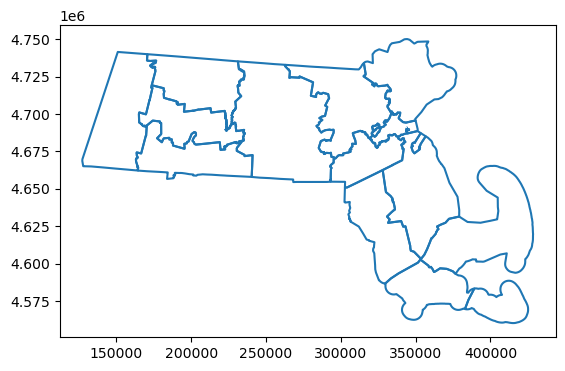

In [8]:
places = [
    "Barnstable County, Massachusetts, United States",
    "Berkshire County, Massachusetts, United States",
    "Bristol County, Massachusetts, United States",
    "Dukes County, Massachusetts, United States",
    "Essex County, Massachusetts, United States",
    "Franklin County, Massachusetts, United States",
    "Hampden County, Massachusetts, United States",
    "Hampshire County, Massachusetts, United States",
    "Middlesex County, Massachusetts, United States",
    "Nantucket County, Massachusetts, United States",
    "Norfolk County, Massachusetts, United States",
    "Plymouth County, Massachusetts, United States",
    "Suffolk County, Massachusetts, United States",
    "Worcester County, Massachusetts, United States"
]

ma_counties = ox.geocoder.geocode_to_gdf(places)
ma_counties_p = ox.projection.project_gdf(ma_counties)
ax = ma_counties_p.boundary.plot()

Then I join the two dataframes together.

In [9]:
joined = gpd.sjoin(ma_solar_p_explode, ma_counties_p, how='left', predicate='intersects')
print(joined.head())

                  barrier  plant:method plant:output:electricity plant:source  \
element  id                                                                     
relation 8521594      NaN  photovoltaic                     1 MW        solar   
         8521594      NaN  photovoltaic                     1 MW        solar   
         8521594      NaN  photovoltaic                     1 MW        solar   
         8521594      NaN  photovoltaic                     1 MW        solar   
         10306360     NaN  photovoltaic                     1 MW        solar   

                   power note owner               name_left ref:US:EIA  \
element  id                                                              
relation 8521594   plant  NaN   NaN       Brewster Landfill      59075   
         8521594   plant  NaN   NaN       Brewster Landfill      59075   
         8521594   plant  NaN   NaN       Brewster Landfill      59075   
         8521594   plant  NaN   NaN       Brewster Landfill   

And finally, I group by the county name, aggregate by the sum of the array areas, and convert the sums to a pretty acreage number.

In [10]:
results = joined.groupby('name_right')['area'].sum()/4046.86
print(results.astype(int))

name_right
Barnstable County     315
Berkshire County      557
Bristol County        989
Dukes County           28
Essex County          310
Franklin County       389
Hampden County       1070
Hampshire County      443
Middlesex County      726
Nantucket               6
Norfolk County        395
Plymouth County      1129
Suffolk County         27
Worcester County     3239
Name: area, dtype: int64
